<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# PyTorch RNN #
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

In [ ]:
import os
import numpy
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
from matplotlib.backends.backend_agg import FigureCanvasAgg
import graphviz

import imageio
import PIL

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
import torch
import scipy

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [ ]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

To understand PyTorch's RNN of <https://pytorch.org/docs/stable/generated/torch.nn.RNN.html>, let's implement some simple linear systems.  We will do this in an approximate way, reflecting the fact that RNN's typically have a nonlinearity.

In [ ]:
SEED=0

# First hidden layer

Let's start with an input sequence $X=(1,-1,0,0)$, which should be understood as $X_0=1$, $X_1=-1$, and so forth.  Let's construct the linear recursion
$h^{(0)}_n=\tfrac12 h^{(0)}_{n-1}+2X_n$, with initial condition $h^{(0)}_{-1}=1$.  Explicitly, this gives us another sequence
$h^{(0)}=(2.5,-0.75,-0.375,-0.1875)$.

We want to think of $h^{(0)}$ as the first (indexed as zero) "hidden" layer.  We will name the weights in our recursion for $h^{(0)}$ as
W_ih_l0=2 (the *input-to-hidden* weight at level 0) and W_hh_l0=1/2 (the *hidden-to-hidden* weight at level 0).  For simplicity, we will set various biases to zero.


In [ ]:
#set up input
X=numpy.array([1,-1,0,0],dtype=numpy.float32)
sequencelength=len(X)
df=pandas.DataFrame(X,columns=["X"])
df

,X
0,1.0
1,-1.0
2,0.0
3,0.0


In [ ]:
#set up dynamics and initial condition for first layer
W_ih_l0=2 #m_zi in notes
W_hh_l0=0.5 #m_zz in notes
h_init_l0=1

In [ ]:
state=h_init_l0
h_0=[]
for n in range(sequencelength):
  state=W_hh_l0*state+W_ih_l0*X[n]
  h_0.append(state)

df["h_0"]=h_0
df

,X,h_0
0,1.0,2.5000
1,-1.0,-0.7500
2,0.0,-0.3750
3,0.0,-0.1875


Let's implement this in pytorch's RNN.  Since $\tanh(x)\approx x$ for small $x$, let's scale everything by $\varepsilon=10^{-3}$

In [ ]:
eps=1E-3
eps

0.001

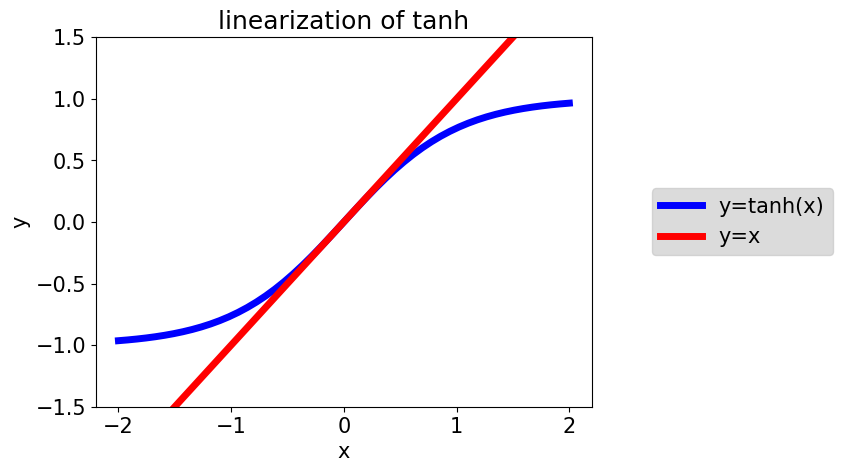

In [ ]:
x=numpy.linspace(-2,2)
y=numpy.tanh(x)
plt.figure()
plt.plot(x,y,color="blue",label="y=tanh(x)")
plt.plot(x,x,label="y=x",color="red")
legend("side")
plt.ylim(-1.5,1.5)
plt.xlabel("x")
plt.ylabel("y")
title=[]
title.append("linearization of tanh")
plt.title("\n".join(title))
plt.show()
plt.close()

In [ ]:
input_size=1 #X is a sequence of scalars
hidden_size=1 #h is a sequence of scalars
num_layers=1 #we have one hidden layer
batchsize=1 #we are doing this for one initial condition
#we have a sequence of length 4
rnn = torch.nn.RNN(input_size, hidden_size, num_layers,bias=False) #no biases
input=torch.from_numpy(eps*X.reshape((sequencelength, batchsize, input_size))) #scale input by epsilon
h0 = torch.from_numpy(eps*numpy.array([h_init_l0],dtype=numpy.float32).reshape((num_layers, batchsize, hidden_size))) #scale initial conditions by epsilon
rnn.weight_ih_l0.data=torch.from_numpy(numpy.array(W_ih_l0,dtype=numpy.float32).reshape(hidden_size,hidden_size))
rnn.weight_hh_l0.data=torch.from_numpy(numpy.array(W_hh_l0,dtype=numpy.float32).reshape(hidden_size,input_size))
output, hn = rnn(input, h0)
print("output=",output)
print("hn=",hn)

output= tensor([[[ 0.0025]],

        [[-0.0008]],

        [[-0.0004]],

        [[-0.0002]]], grad_fn=<StackBackward0>)
hn= tensor([[[-0.0002]]], grad_fn=<StackBackward0>)


In [ ]:
df["h_0_pytorch"]=output.detach().squeeze()
df

,X,h_0,h_0_pytorch
0,1.0,2.5000,0.002500
1,-1.0,-0.7500,-0.000750
2,0.0,-0.3750,-0.000375
3,0.0,-0.1875,-0.000188


# Second hidden layer

Let's next construct a second hidden layer, which is driven by $h^{(0)}$, and has the dynamics $h^{(1)}_n=h^{(1)}_{n-1}+h^{(0)}_n$, with initial condition $h^{(1)}_{-1}=1$.  Explicitly, this gives us another sequence
$h^{(1)}=(3.5,2.75,2.375,2.1875)$.

We want to think of $h^{(1)}$ as the second (indexed as 1) "hidden" layer.  We will name the weights in our recursion for $h^{(1)}$ as
W_ih_l1=1 (the *input-to-hidden* weight at level 1) and W_hh_l1=1 (the *hidden-to-hidden* weight at level 1).  Again, we will set various biases to zero.

In [ ]:
#set up dynamics and initial condition for second layer
W_ih_l1=1
W_hh_l1=1
h_init_l1=1

In [ ]:
state=h_init_l1
h_1=[]
for n in range(sequencelength):
  state=W_hh_l1*state+W_ih_l1*h_0[n]
  h_1.append(state)

df["h_1"]=h_1
df

,X,h_0,h_0_pytorch,h_1
0,1.0,2.5000,0.002500,3.5000
1,-1.0,-0.7500,-0.000750,2.7500
2,0.0,-0.3750,-0.000375,2.3750
3,0.0,-0.1875,-0.000188,2.1875


Let's implement this in pytorch's RNN.  Pytorch will internally repeat the above calculations for $h^{(0)}$, and the final output will be $h^{(1)}$.

In [ ]:
input_size=1 #X is a sequence of scalars
hidden_size=1 #h is a sequence of scalars
num_layers=2 #we have one hidden layer
batchsize=1 #we are doing this for one initial condition
#we have a sequence of length 4
rnn = torch.nn.RNN(input_size, hidden_size, num_layers,bias=False) #no biases
input=torch.from_numpy(eps*X.reshape((sequencelength, batchsize, input_size))) #scale input by epsilon
h0 = torch.from_numpy(eps*numpy.array([h_init_l0,h_init_l1],dtype=numpy.float32).reshape((num_layers, batchsize, hidden_size))) #scale initial conditions by epsilon
rnn.weight_ih_l0.data=torch.from_numpy(numpy.array(W_ih_l0,dtype=numpy.float32).reshape(hidden_size,hidden_size))
rnn.weight_hh_l0.data=torch.from_numpy(numpy.array(W_hh_l0,dtype=numpy.float32).reshape(hidden_size,input_size))
rnn.weight_ih_l1.data=torch.from_numpy(numpy.array(W_ih_l1,dtype=numpy.float32).reshape(hidden_size,hidden_size))
rnn.weight_hh_l1.data=torch.from_numpy(numpy.array(W_hh_l1,dtype=numpy.float32).reshape(hidden_size,hidden_size))
output, hn = rnn(input, h0)
print("output=",output)
print("hn=",hn)

output= tensor([[[0.0035]],

        [[0.0027]],

        [[0.0024]],

        [[0.0022]]], grad_fn=<StackBackward0>)
hn= tensor([[[-0.0002]],

        [[ 0.0022]]], grad_fn=<StackBackward0>)


In [ ]:
df["h_1_pytorch"]=output.detach().squeeze()
df

,X,h_0,h_0_pytorch,h_1,h_1_pytorch
0,1.0,2.5000,0.002500,3.5000,0.003500
1,-1.0,-0.7500,-0.000750,2.7500,0.002750
2,0.0,-0.3750,-0.000375,2.3750,0.002375
3,0.0,-0.1875,-0.000188,2.1875,0.002187


# Nonlinearities

To make sure that we understand things, let's redo the first hidden layer $h^{(0)}$ but include the full $\tanh$ nonlinearity (by setting $\varepsilon=1$).

Here we explicitly have $h^{(0),nl}_n=\tanh\left(\tfrac12 h^{(0),nl}_{n-1}+2X_n\right)$

In [ ]:
state=h_init_l0
h_nl_0=[]
for n in range(sequencelength):
  state=numpy.tanh(W_hh_l0*state+W_ih_l0*X[n])
  h_nl_0.append(state)

h_nl_0

[0.9866142981514303,
 -0.9063503956872477,
 -0.42450552129914076,
 -0.20912175455437776]

In [ ]:
input_size=1 #X is a sequence of scalars
hidden_size=1 #h is a sequence of scalars
num_layers=1 #we have one hidden layer
batchsize=1 #we are doing this for one initial condition
#we have a sequence of length 4
rnn = torch.nn.RNN(input_size, hidden_size, num_layers,bias=False) #no biases
input=torch.from_numpy(X.reshape((sequencelength, batchsize, input_size)))
h0 = torch.from_numpy(numpy.array([h_init_l0],dtype=numpy.float32).reshape((num_layers, batchsize, hidden_size)))
rnn.weight_ih_l0.data=torch.from_numpy(numpy.array(W_ih_l0,dtype=numpy.float32).reshape(hidden_size,hidden_size))
rnn.weight_hh_l0.data=torch.from_numpy(numpy.array(W_hh_l0,dtype=numpy.float32).reshape(hidden_size,input_size))
output, hn = rnn(input, h0)
output

tensor([[[ 0.9866]],

        [[-0.9064]],

        [[-0.4245]],

        [[-0.2091]]], grad_fn=<StackBackward0>)

# Let's now learn an RNN

In [ ]:
alpha=0.5 #weight_hh_l0
beta=2.0 #weight_ih_l0
eps=1E-3
input_size=1 #X is a sequence of scalars
hidden_size=1 #h is a sequence of scalars
num_layers=1 #we have one hidden layer
batchsize=2 #we are doing this for two initial conditions
sequencelength=10 #we have a sequence of length 10

In [ ]:
#let's generate two samples of our recursion.
#Let's be as explicit as possible to make sure that we know what roles various dimensions play

numpy.random.seed(1) #seed = 1 gives better results than seed=0
trainingsamples=[]
initialconditions=[]
for n in range(batchsize):
  X=eps*numpy.random.rand(sequencelength)
  h_init=eps*numpy.random.rand()
  initialconditions.append(h_init)
  state=h_init
  Y=[]
  for n in range(sequencelength):
    state=alpha*state+beta*X[n]
    Y.append(state)
  data=pandas.DataFrame({"input":X,"output":Y})
  data.index.name="n"
  trainingsamples.append(data)
print("trainingsamples: ",trainingsamples)
print("initial conditions: ",initialconditions)

trainingsamples:  [          input    output
n                        
0  4.170220e-04  0.001044
1  7.203245e-04  0.001962
2  1.143748e-07  0.000981
3  3.023326e-04  0.001095
4  1.467559e-04  0.000841
5  9.233859e-05  0.000605
6  1.862602e-04  0.000675
7  3.455607e-04  0.001029
8  3.967675e-04  0.001308
9  5.388167e-04  0.001732,       input    output
n                    
0  0.000685  0.001855
1  0.000204  0.001336
2  0.000878  0.002424
3  0.000027  0.001267
4  0.000670  0.001974
5  0.000417  0.001822
6  0.000559  0.002028
7  0.000140  0.001295
8  0.000198  0.001044
9  0.000801  0.002123]
initial conditions:  [0.0004191945144032948, 0.0009682615757193975]


In [ ]:
#construct input and output arrays
#construct batch-first lists of inputs and outputs
inputs=numpy.array([df["input"] for df in trainingsamples],
                   dtype=numpy.float32).reshape((batchsize,sequencelength,input_size))
inputs=torch.from_numpy(inputs)
print("inputs: ",inputs)
h_inits=numpy.array(initialconditions,dtype=numpy.float32).reshape((num_layers, batchsize, hidden_size))
h_inits=torch.from_numpy(h_inits)
print("h_inits: ",h_inits)
outputs=numpy.array([df["output"] for df in trainingsamples],
                    dtype=numpy.float32).reshape((batchsize,sequencelength,hidden_size))
outputs=torch.from_numpy(outputs)
print("outputs: ",outputs)

inputs:  tensor([[[4.1702e-04],
         [7.2032e-04],
         [1.1437e-07],
         [3.0233e-04],
         [1.4676e-04],
         [9.2339e-05],
         [1.8626e-04],
         [3.4556e-04],
         [3.9677e-04],
         [5.3882e-04]],

        [[6.8522e-04],
         [2.0445e-04],
         [8.7812e-04],
         [2.7388e-05],
         [6.7047e-04],
         [4.1730e-04],
         [5.5869e-04],
         [1.4039e-04],
         [1.9810e-04],
         [8.0074e-04]]])
h_inits:  tensor([[[0.0004],
         [0.0010]]])
outputs:  tensor([[[0.0010],
         [0.0020],
         [0.0010],
         [0.0011],
         [0.0008],
         [0.0006],
         [0.0007],
         [0.0010],
         [0.0013],
         [0.0017]],

        [[0.0019],
         [0.0013],
         [0.0024],
         [0.0013],
         [0.0020],
         [0.0018],
         [0.0020],
         [0.0013],
         [0.0010],
         [0.0021]]])


In [ ]:
#let's check RNN to recover the output from input
num_layers=1
rnn = torch.nn.RNN(input_size, hidden_size, num_layers,batch_first=True,bias=False) #no biases
rnn.weight_ih_l0.data=torch.from_numpy(numpy.array(beta,dtype=numpy.float32).reshape(hidden_size,input_size))
rnn.weight_hh_l0.data=torch.from_numpy(numpy.array(alpha,dtype=numpy.float32).reshape(hidden_size,hidden_size))
output, hn = rnn(inputs,h_inits)
output

tensor([[[0.0010],
         [0.0020],
         [0.0010],
         [0.0011],
         [0.0008],
         [0.0006],
         [0.0007],
         [0.0010],
         [0.0013],
         [0.0017]],

        [[0.0019],
         [0.0013],
         [0.0024],
         [0.0013],
         [0.0020],
         [0.0018],
         [0.0020],
         [0.0013],
         [0.0010],
         [0.0021]]], grad_fn=<TransposeBackward1>)

In [ ]:
class myRNN(torch.nn.Module):
    def __init__(self, inputSize=1, hiddenSize=1,numlayers=1,batchsize=1,SEED=None): #default to one-dimensional feature and response
        if SEED is not None:
          torch.manual_seed(SEED)
        super().__init__() #run init of torch.nn.Module
        self.rnn = torch.nn.RNN(inputSize, hiddenSize,num_layers,batch_first=True,bias=False)
        self.h_init=torch.nn.Parameter(torch.zeros(numlayers, batchsize, hiddenSize), requires_grad=True)
        if torch.cuda.is_available():
          self=self.cuda()

    def forward(self, inputs):
        out,_=self.rnn(inputs,self.h_init)
        return out

In [ ]:

model=myRNN(batchsize=2,SEED=SEED)

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

MAX_iter = 10000
for itr in range(MAX_iter):

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    predictions = model(inputs)

    # get loss for the predicted output
    lossvalue = Loss(outputs, predictions)

    # get gradients w.r.t to parameters
    lossvalue.backward()
    #print(model.linear.weight.grad.item(),model.linear.bias.grad.item())

    # update parameters
    optimizer.step()
    if itr%int(MAX_iter/20)==0:
      print("iteration {}: loss={:.5f}; weight_ih_l0 (beta)={:.3f}, weight_hh_l0 (alpha)={:.3f}".format(itr, lossvalue.item(),model.rnn.weight_ih_l0.item(),model.rnn.weight_hh_l0.item()))

iteration 0: loss=0.00000; weight_ih_l0 (beta)=-0.006, weight_hh_l0 (alpha)=0.536
iteration 500: loss=0.00000; weight_ih_l0 (beta)=0.303, weight_hh_l0 (alpha)=0.917
iteration 1000: loss=0.00000; weight_ih_l0 (beta)=0.376, weight_hh_l0 (alpha)=0.901
iteration 1500: loss=0.00000; weight_ih_l0 (beta)=0.480, weight_hh_l0 (alpha)=0.875
iteration 2000: loss=0.00000; weight_ih_l0 (beta)=0.617, weight_hh_l0 (alpha)=0.841
iteration 2500: loss=0.00000; weight_ih_l0 (beta)=0.783, weight_hh_l0 (alpha)=0.800
iteration 3000: loss=0.00000; weight_ih_l0 (beta)=0.976, weight_hh_l0 (alpha)=0.752
iteration 3500: loss=0.00000; weight_ih_l0 (beta)=1.183, weight_hh_l0 (alpha)=0.701
iteration 4000: loss=0.00000; weight_ih_l0 (beta)=1.390, weight_hh_l0 (alpha)=0.650
iteration 4500: loss=0.00000; weight_ih_l0 (beta)=1.580, weight_hh_l0 (alpha)=0.603
iteration 5000: loss=0.00000; weight_ih_l0 (beta)=1.740, weight_hh_l0 (alpha)=0.564
iteration 5500: loss=0.00000; weight_ih_l0 (beta)=1.858, weight_hh_l0 (alpha)=0